In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna

from sklearn.metrics import mean_squared_error
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [3]:
X_train = pd.read_csv("../01_data/02_processed/production/X_train_nonlinear.csv")
y_train = pd.read_csv("../01_data/02_processed/production/y_train.csv").squeeze()

X_test = pd.read_csv("../01_data/02_processed/production/X_test_nonlinear.csv")
y_test = pd.read_csv("../01_data/02_processed/production/y_test.csv").squeeze()

print(X_train.shape, X_test.shape)


(34754, 26) (8689, 26)


In [4]:
def objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "n_estimators": trial.suggest_int("n_estimators", 400, 1200),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist"
    }

    model = xgb.XGBRegressor(**params)

    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=120, timeout=600)


[I 2026-02-27 09:51:30,288] A new study created in memory with name: no-name-bed460a6-82e2-4ce4-b27f-178ab816dce1
[I 2026-02-27 09:51:34,099] Trial 0 finished with value: 23.672077178955078 and parameters: {'max_depth': 9, 'learning_rate': 0.03898528387964569, 'n_estimators': 1180, 'min_child_weight': 4, 'subsample': 0.6435138246160077, 'colsample_bytree': 0.6068241907739559, 'gamma': 1.3382512202642871, 'reg_alpha': 4.512699908377566, 'reg_lambda': 0.7449180984721421}. Best is trial 0 with value: 23.672077178955078.
[I 2026-02-27 09:51:36,333] Trial 1 finished with value: 22.61364682515462 and parameters: {'max_depth': 6, 'learning_rate': 0.023329882570556668, 'n_estimators': 1015, 'min_child_weight': 1, 'subsample': 0.6923400465907819, 'colsample_bytree': 0.8040874701290497, 'gamma': 1.1364624111877757, 'reg_alpha': 2.130622384733357, 'reg_lambda': 1.0639968696461821}. Best is trial 1 with value: 22.61364682515462.
[I 2026-02-27 09:51:37,911] Trial 2 finished with value: 23.692383448

In [7]:
print("Optuna_CV_RMSE:", study.best_value)

print("Optuna_Best_Params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_params = study.best_params


Optuna_CV_RMSE: 22.070659001668293
Optuna_Best_Params:
max_depth: 9
learning_rate: 0.010282552028938605
n_estimators: 617
min_child_weight: 9
subsample: 0.8856216033143729
colsample_bytree: 0.8599984598848831
gamma: 3.707696795247694
reg_alpha: 4.777388759133268
reg_lambda: 1.27974690495927


In [136]:
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

final_model.fit(X_train, y_train)


# 예측
train_pred = final_model.predict(X_train)
test_pred  = final_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train_RMSE : {train_rmse:.3f}")
print(f"Test_RMSE : {test_rmse:.3f}")


Train_RMSE : 20.043
Test_RMSE : 22.003


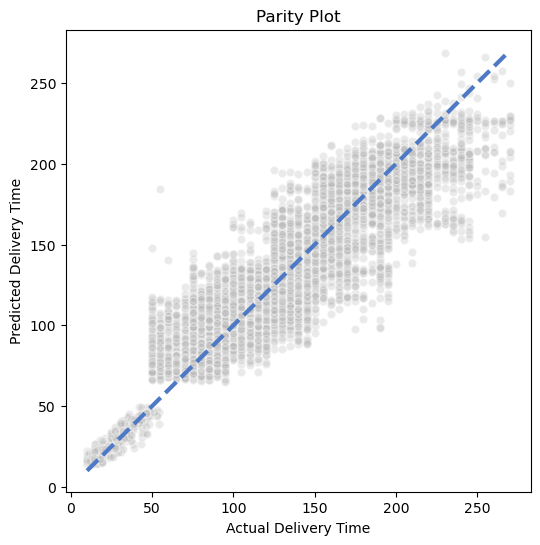

In [11]:
# 잔차 계산
residuals = y_test - test_pred

# Figure 1. 예측값–실제값 비교 그래프
plt.figure(figsize = (6,6))
plt.scatter(y_test, test_pred, alpha = 0.3, color = "#BBBBBB", edgecolors = "white")

min_val = min(y_test.min(), test_pred.min())
max_val = max(y_test.max(), test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color = "#4E79C5", linestyle = "--", linewidth = 3)

plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Parity Plot")
plt.savefig("../04_results/xgboost/fig1.png", dpi = 300, bbox_inches = "tight")
plt.show()



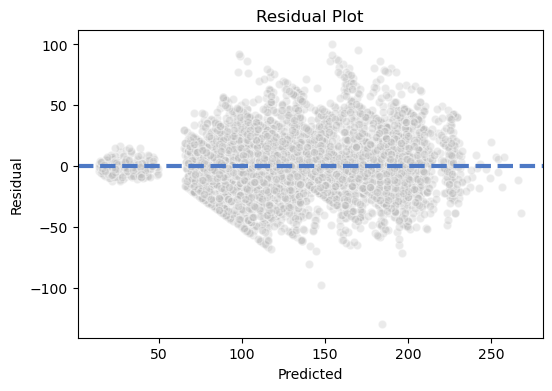

In [12]:
# Figure 2. 잔차 그래프
plt.figure(figsize = (6,4))
plt.scatter(test_pred, residuals, alpha = 0.3, color = "#BBBBBB", edgecolors = "white")

plt.axhline(0, color = "#4E79C5", linestyle = "--", linewidth = 3)

plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.savefig("../04_results/xgboost/fig2.png", dpi = 300, bbox_inches = "tight")
plt.show()


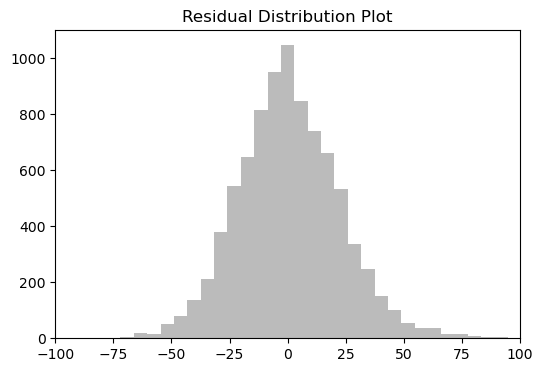

In [13]:
# Figure 3. 잔차 분포 히스토그램
plt.figure(figsize = (6,4))
plt.hist(residuals, bins = 40, color = "#BBBBBB")

plt.xlim(-100, 100)

plt.title("Residual Distribution Plot")
plt.savefig("../04_results/xgboost/fig3.png", dpi = 300, bbox_inches = "tight")
plt.show()


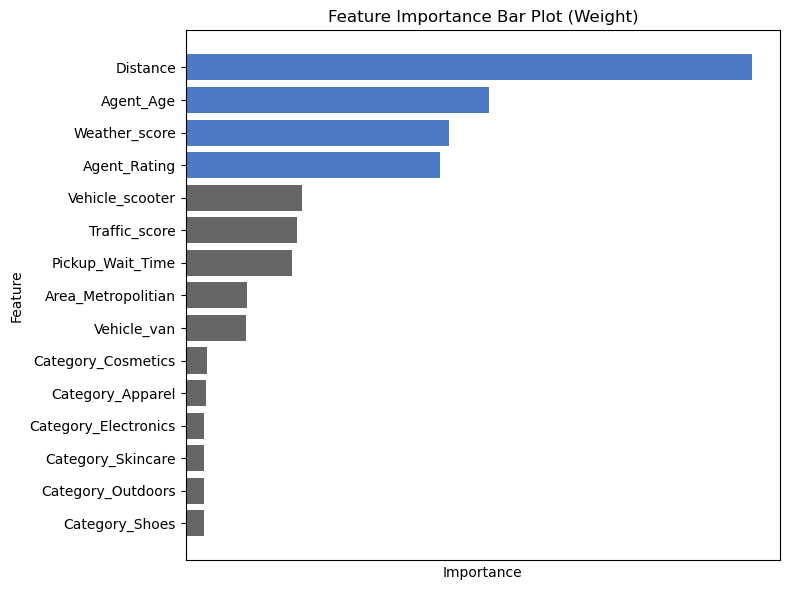

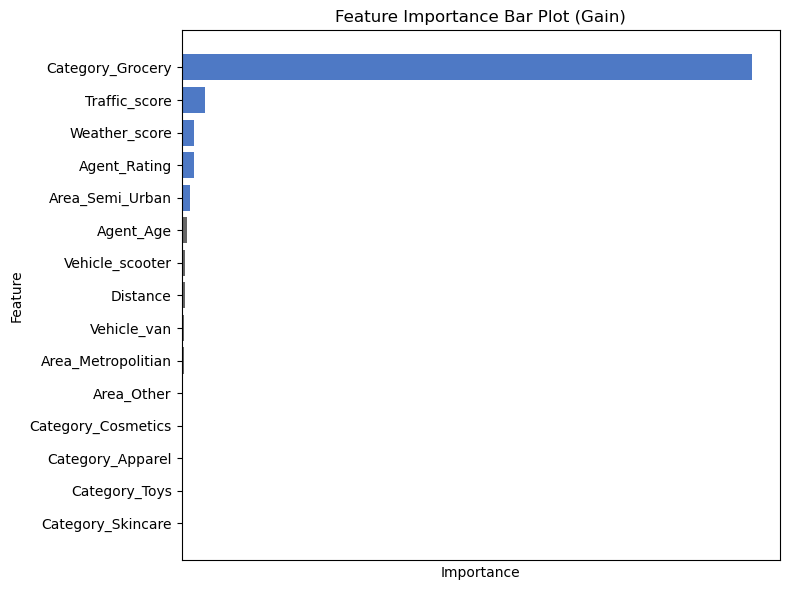

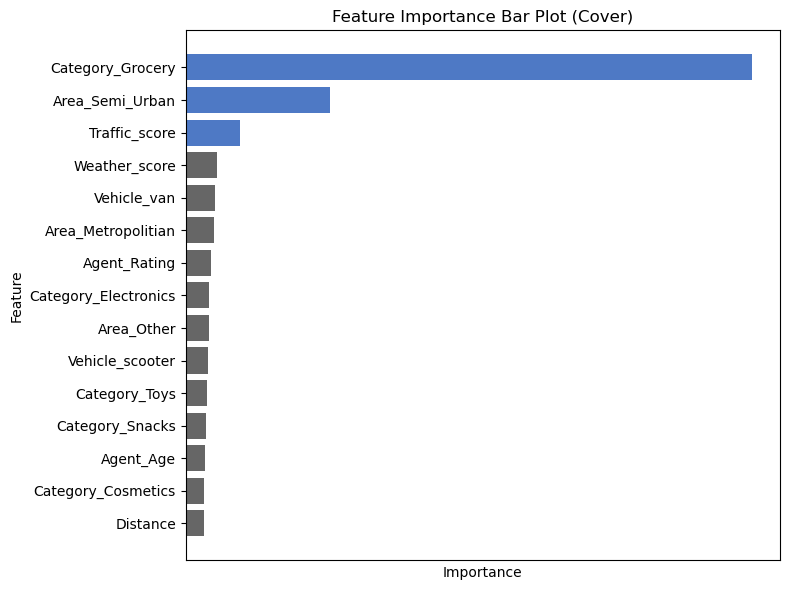

In [45]:
# Figure 4~6. XGBoost 중요도 (상위 변수 강조 색상)
booster = final_model.get_booster()

def plot_xgb_importance_custom(importance_type, highlight_top_n, title, save_path, max_features = 15):
    score_dict = booster.get_score(importance_type = importance_type)

    imp_df = pd.DataFrame(list(score_dict.items()), columns = ["feature", "importance"])
    imp_df = imp_df.sort_values("importance", ascending = False).head(max_features).reset_index(drop = True)

    # 상위 n개만 파란색, 나머지는 회색
    imp_df["color"] = "#666666"
    imp_df.loc[imp_df.index < highlight_top_n, "color"] = "#4E79C5"

    plot_df = imp_df.iloc[::-1]

    plt.figure(figsize = (8, 6))
    plt.barh(plot_df["feature"], plot_df["importance"], color = plot_df["color"])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.xticks([])  # 중요도 숫자 눈금 숨김
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    plt.show()

# Figure 4: weight 상위 4개 강조
plot_xgb_importance_custom(
    importance_type = "weight",
    highlight_top_n = 4,
    title = "Feature Importance Bar Plot (Weight)",
    save_path = "../04_results/xgboost/fig4.png"
)

# Figure 5: gain 상위 5개 강조
plot_xgb_importance_custom(
    importance_type = "gain",
    highlight_top_n = 5,
    title = "Feature Importance Bar Plot (Gain)",
    save_path = "../04_results/xgboost/fig5.png"
)

# Figure 6: cover 상위 3개 강조
plot_xgb_importance_custom(
    importance_type = "cover",
    highlight_top_n = 3,
    title = "Feature Importance Bar Plot (Cover)",
    save_path = "../04_results/xgboost/fig6.png"
)





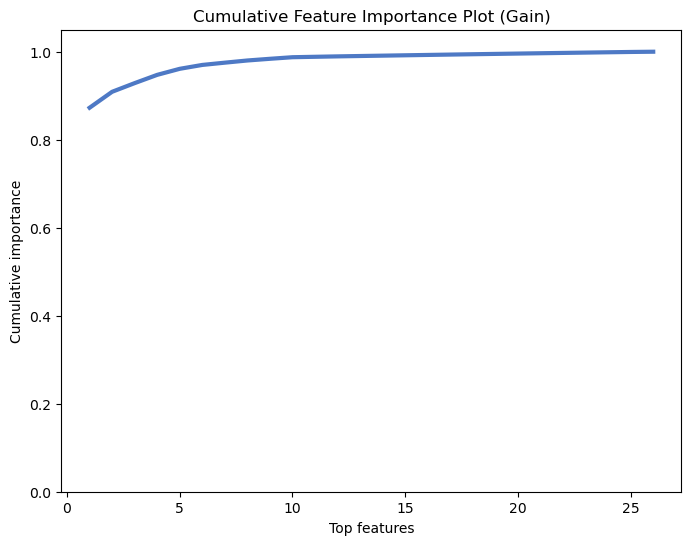

In [43]:
# Figure 7. Cumulative Feature Importance Plot (Normalized Gain)
booster = final_model.get_booster()
gain_scores = booster.get_score(importance_type = "gain")

gain_df = pd.DataFrame(list(gain_scores.items()), columns = ["feature", "gain"])
gain_df = gain_df.sort_values("gain", ascending = False).reset_index(drop = True)

gain_df["gain_norm"] = gain_df["gain"] / gain_df["gain"].sum()
gain_df["cum_gain_norm"] = gain_df["gain_norm"].cumsum()

plt.figure(figsize = (8,6))
plt.plot(range(1, len(gain_df) + 1), gain_df["cum_gain_norm"], color = "#4E79C5", linewidth = 3)
plt.ylim(0, 1.05)
plt.xlabel("Top features")
plt.ylabel("Cumulative importance")
plt.title("Cumulative Feature Importance Plot (Gain)")
plt.savefig("../04_results/xgboost/fig7.png", dpi = 300, bbox_inches = "tight")
plt.show()




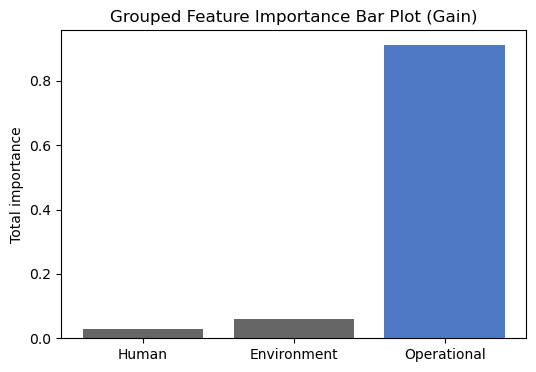

In [44]:
# Figure 8. Grouped Feature Importance Bar Plot (Normalized Gain Sum)
booster = final_model.get_booster()
gain_scores = booster.get_score(importance_type = "gain")

gain_df = pd.DataFrame(list(gain_scores.items()), columns = ["feature", "gain"])
gain_df["gain_norm"] = gain_df["gain"] / gain_df["gain"].sum()

def map_group(feature_name):
    if feature_name in ["Agent_Age", "Agent_Rating"]:
        return "Human"
    if feature_name in ["Weather_score", "Traffic_score", "Distance"]:
        return "Environment"
    if (
        feature_name.startswith("Vehicle_")
        or feature_name.startswith("Area_")
        or feature_name.startswith("Category_")
        or feature_name == "Pickup_Wait_Time"
    ):
        return "Operational"
    return "Other"

gain_df["group"] = gain_df["feature"].apply(map_group)
group_gain = gain_df.groupby("group", as_index = False)["gain_norm"].sum()

plot_order = ["Human", "Environment", "Operational", "Other"]
group_gain["order"] = group_gain["group"].apply(lambda x: plot_order.index(x) if x in plot_order else 99)
group_gain = group_gain.sort_values("order")

colors = ["#666666"] * len(group_gain)
if "Operational" in group_gain["group"].values:
    op_pos = group_gain.reset_index(drop=True).index[group_gain.reset_index(drop=True)["group"] == "Operational"][0]
    colors[op_pos] = "#4E79C5"

plt.figure(figsize = (6,4))
plt.bar(group_gain["group"], group_gain["gain_norm"], color = colors)
plt.ylabel("Total importance")
plt.title("Grouped Feature Importance Bar Plot (Gain)")
plt.savefig("../04_results/xgboost/fig8.png", dpi = 300, bbox_inches = "tight")
plt.show()




In [47]:
# PDP/ICE용 타입 정리 (RF 노트북과 동일 변수)
for col in ["Weather_score", "Traffic_score", "Agent_Age"]:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(float)


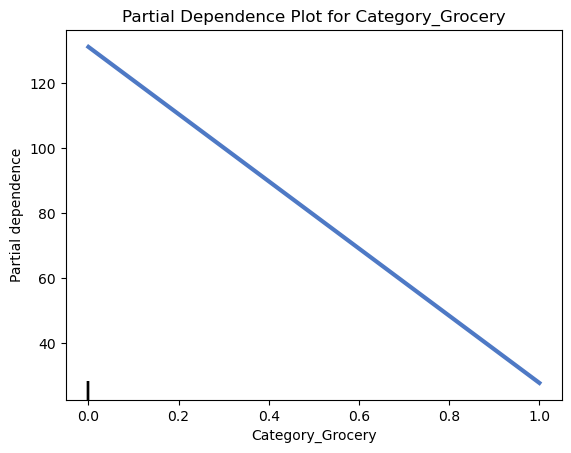

In [48]:
# PDP Category_Grocery
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Category_Grocery"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Category_Grocery")
plt.savefig("../04_results/xgboost/fig9_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




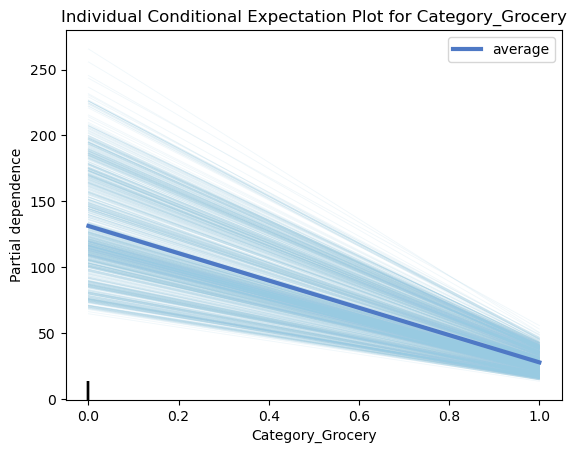

In [49]:
# PDP+ICE Category_Grocery
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Category_Grocery"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Category_Grocery")
plt.savefig("../04_results/xgboost/fig9_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




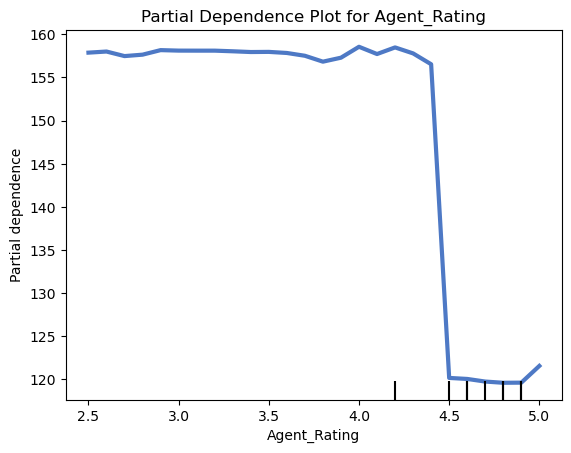

In [50]:
# PDP Agent_Rating
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Agent_Rating"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Agent_Rating")
plt.savefig("../04_results/xgboost/fig10_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




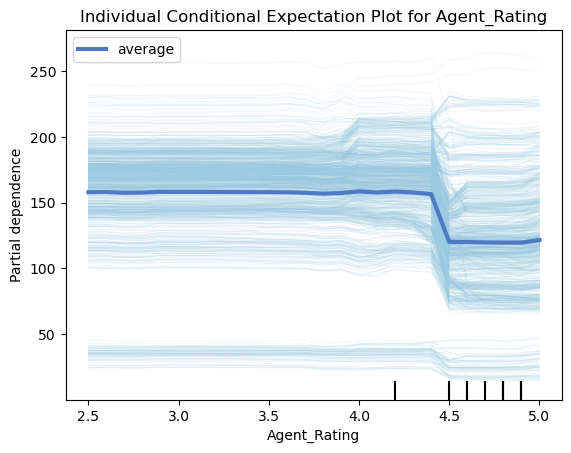

In [51]:
# PDP+ICE Agent_Rating
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Agent_Rating"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Agent_Rating")
plt.savefig("../04_results/xgboost/fig10_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




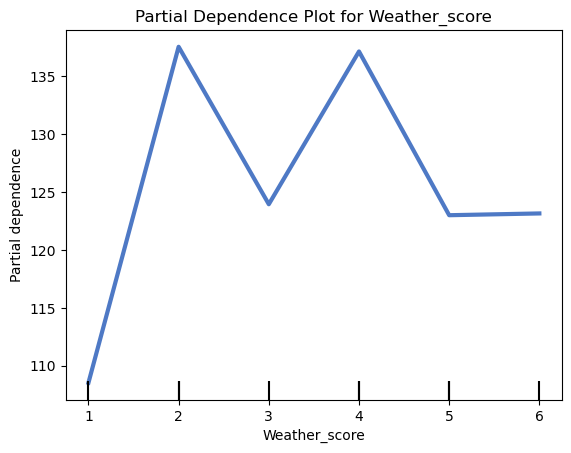

In [52]:
# PDP Weather_score
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Weather_score"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Weather_score")
plt.savefig("../04_results/xgboost/fig11_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




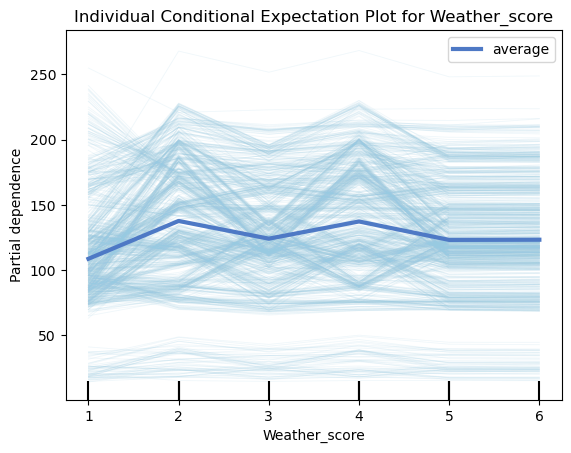

In [53]:
# PDP+ICE Weather_score
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Weather_score"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Weather_score")
plt.savefig("../04_results/xgboost/fig11_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




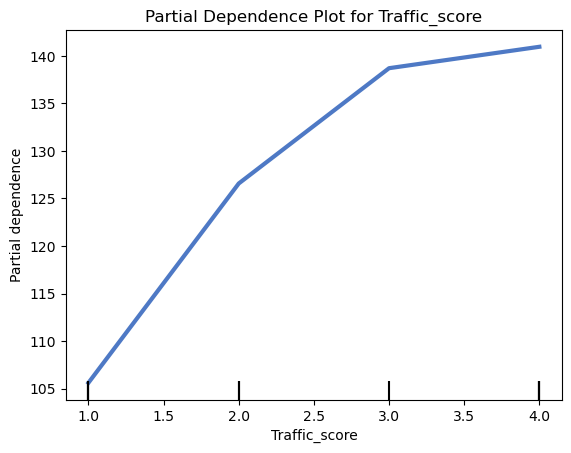

In [ ]:
# PDP Traffic_score
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Traffic_score"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Traffic_score")
plt.savefig("../04_results/xgboost/fig12_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




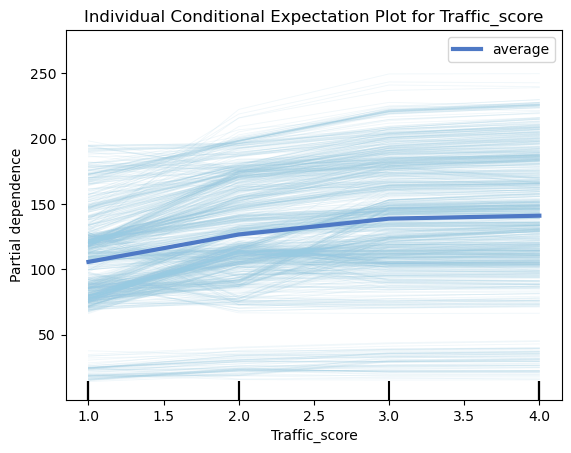

In [55]:
# PDP+ICE Traffic_score
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Traffic_score"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Traffic_score")
plt.savefig("../04_results/xgboost/fig12_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




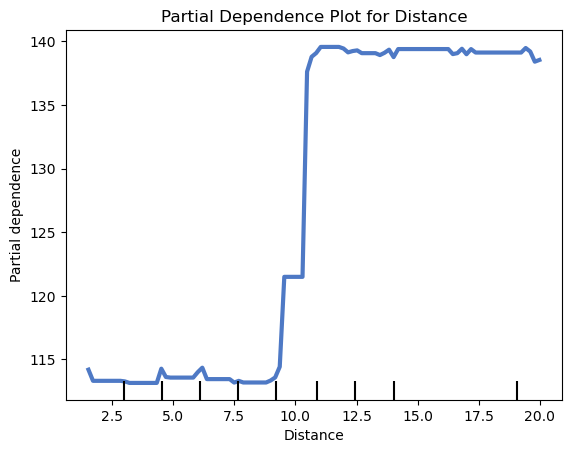

In [56]:
# PDP Distance
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Distance"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Distance")
plt.savefig("../04_results/xgboost/fig13_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




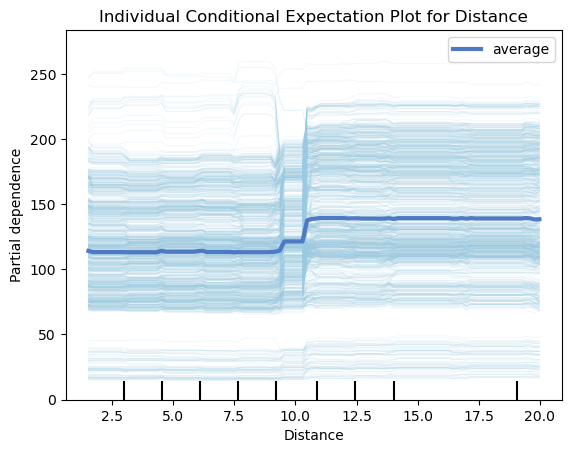

In [57]:
# PDP+ICE Distance
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Distance"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Distance")
plt.savefig("../04_results/xgboost/fig13_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




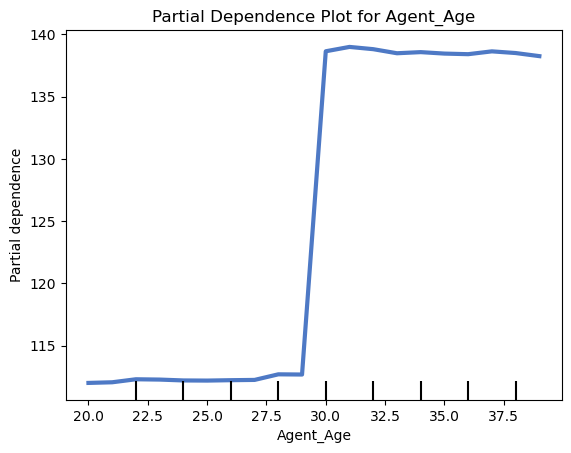

In [58]:
# PDP Agent_Age
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Agent_Age"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Agent_Age")
plt.savefig("../04_results/xgboost/fig14_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




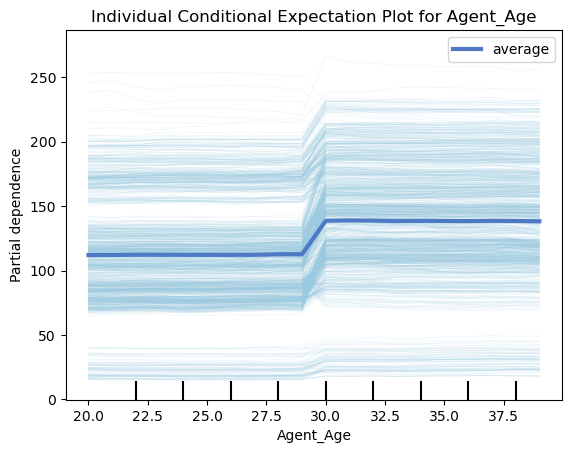

In [59]:
# PDP+ICE Agent_Age
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Agent_Age"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Agent_Age")
plt.savefig("../04_results/xgboost/fig14_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




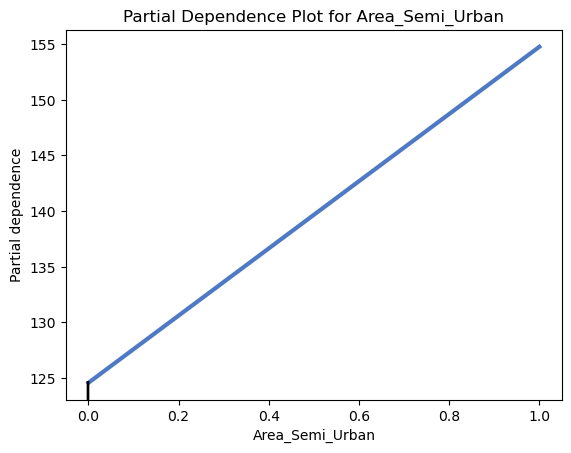

In [60]:
# PDP Area_Semi_Urban
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Area_Semi_Urban"],
    kind = "average",
    grid_resolution = 100,
    line_kw = {"color": "#4E79C5", "linewidth": 3}
)
plt.title("Partial Dependence Plot for Area_Semi_Urban")
plt.savefig("../04_results/xgboost/fig15_1.png", dpi = 300, bbox_inches = "tight")
plt.show()




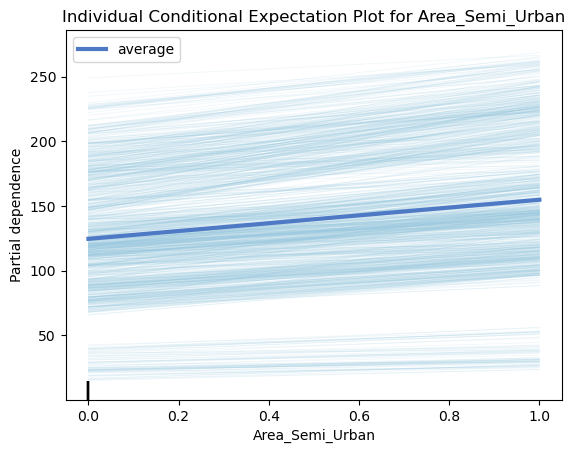

In [61]:
# PDP+ICE Area_Semi_Urban
PartialDependenceDisplay.from_estimator(
    final_model,
    X_train,
    ["Area_Semi_Urban"],
    kind = "both",
    subsample = 1000,
    grid_resolution = 100,
    ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
    pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"}
)
plt.title("Individual Conditional Expectation Plot for Area_Semi_Urban")
plt.savefig("../04_results/xgboost/fig15_2.png", dpi = 300, bbox_inches = "tight")
plt.show()




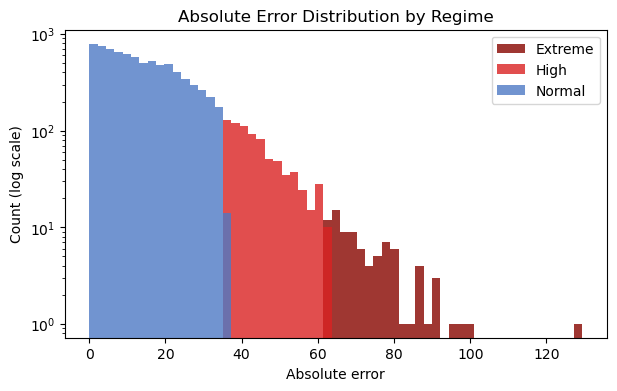

regime
Normal     7820
High        782
Extreme      87
Name: count, dtype: int64

In [130]:
# Figure 16. Absolute Error Distribution by Regime (Q90/Q99)
abs_error = np.abs(y_test - test_pred)

q90 = abs_error.quantile(0.90)
q99 = abs_error.quantile(0.99)

error_df = pd.DataFrame({"abs_error": abs_error})
error_df["regime"] = "Normal"
error_df.loc[(error_df["abs_error"] >= q90) & (error_df["abs_error"] < q99), "regime"] = "High"
error_df.loc[error_df["abs_error"] >= q99, "regime"] = "Extreme"

plt.figure(figsize = (7,4))
bins = np.linspace(0, error_df["abs_error"].max(), 60)

plt.hist(error_df.loc[error_df["regime"] == "Extreme", "abs_error"], bins = bins, color = "#95211B", alpha = 0.9, label = "Extreme")
plt.hist(error_df.loc[error_df["regime"] == "High", "abs_error"], bins = bins, color = "#DA2222", alpha = 0.8, label = "High")
plt.hist(error_df.loc[error_df["regime"] == "Normal", "abs_error"], bins = bins, color = "#4E79C5", alpha = 0.8, label = "Normal")

plt.yscale("log")
plt.xlabel("Absolute error")
plt.ylabel("Count (log scale)")
plt.title("Absolute Error Distribution by Regime")
plt.legend()
plt.savefig("../04_results/xgboost/fig16.png", dpi = 300, bbox_inches = "tight")
plt.show()

error_df["regime"].value_counts()



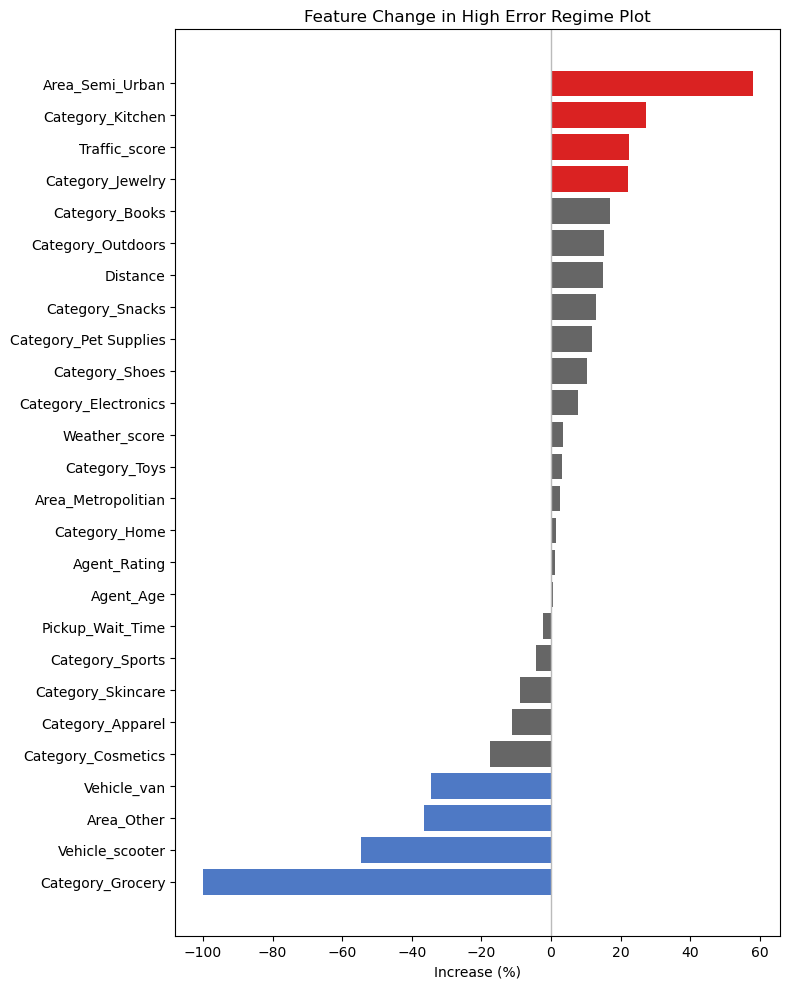

In [133]:
# Normal 대비 High 변화율(%) 가로 막대그래프 (전 변수 포함)
profile_df = X_test.copy()
profile_df["regime"] = error_df["regime"].values

regime_mean_table = profile_df.groupby("regime").mean(numeric_only = True).reindex(["Normal", "High", "Extreme"])

normal_mean = regime_mean_table.loc["Normal"]
high_mean = regime_mean_table.loc["High"]

high_change = (high_mean - normal_mean) / (normal_mean + 1e-9) * 100
high_change = high_change.sort_values(ascending = False)

pos_top4 = set(high_change[high_change > 0].sort_values(ascending = False).head(4).index)
neg_top4 = set(high_change[high_change < 0].sort_values(ascending = True).head(4).index)

colors = []
for feat, val in high_change.items():
    if feat in pos_top4:
        colors.append("#DA2222")
    elif feat in neg_top4:
        colors.append("#4E79C5")
    else:
        colors.append("#666666")

plt.figure(figsize = (8,10))
plt.barh(high_change.index[::-1], high_change.values[::-1], color = colors[::-1])
plt.axvline(0, color = "#BBBBBB", linewidth = 1)
plt.title("Feature Change in High Error Regime Plot")
plt.xlabel("Increase (%)")
plt.tight_layout()
plt.savefig("../04_results/xgboost/fig17.png", dpi = 300, bbox_inches = "tight")
plt.show()



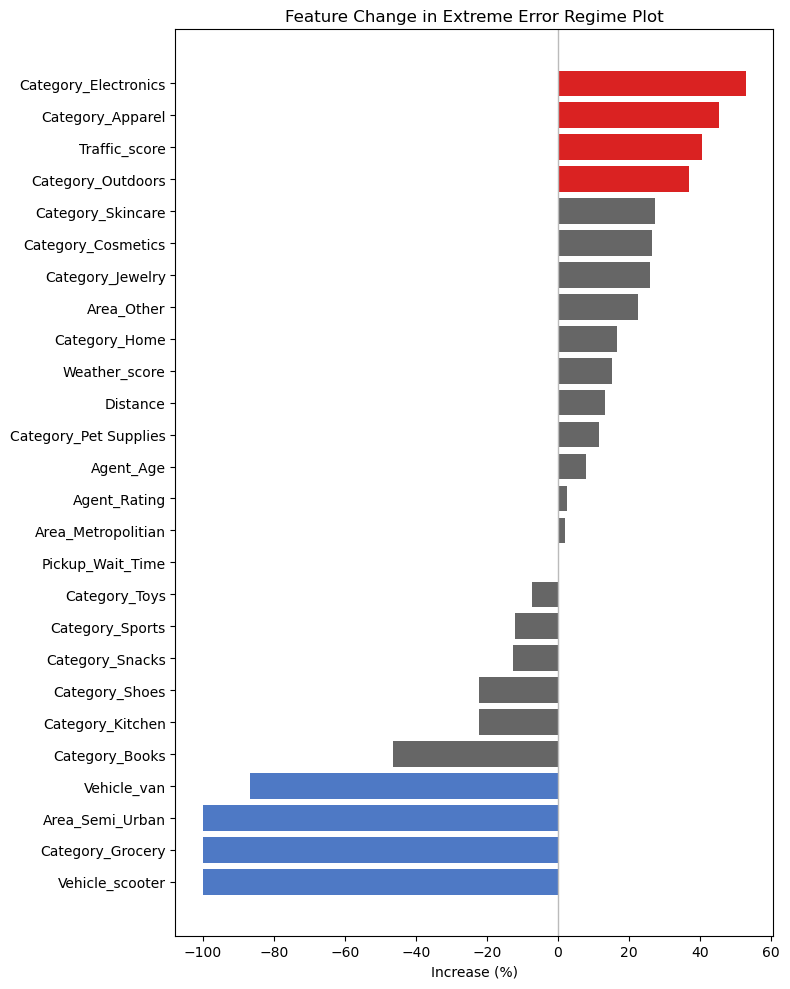

In [134]:
# Normal 대비 Extreme 변화율(%) 가로 막대그래프 (전 변수 포함)
normal_mean = regime_mean_table.loc["Normal"]
extreme_mean = regime_mean_table.loc["Extreme"]

extreme_change = (extreme_mean - normal_mean) / (normal_mean + 1e-9) * 100
extreme_change = extreme_change.sort_values(ascending = False)

pos_top4 = set(extreme_change[extreme_change > 0].sort_values(ascending = False).head(4).index)
neg_top4 = set(extreme_change[extreme_change < 0].sort_values(ascending = True).head(4).index)

colors = []
for feat, val in extreme_change.items():
    if feat in pos_top4:
        colors.append("#DA2222")
    elif feat in neg_top4:
        colors.append("#4E79C5")
    else:
        colors.append("#666666")

plt.figure(figsize = (8,10))
plt.barh(extreme_change.index[::-1], extreme_change.values[::-1], color = colors[::-1])
plt.axvline(0, color = "#BBBBBB", linewidth = 1)
plt.title("Feature Change in Extreme Error Regime Plot")
plt.xlabel("Increase (%)")
plt.tight_layout()
plt.savefig("../04_results/xgboost/fig18.png", dpi = 300, bbox_inches = "tight")
plt.show()

